# Import Required Repositories

In [1]:
!nvidia-smi

Thu May  5 01:53:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers
!pip install pytorch-lightning
!pip install langdetect

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 880 kB 65.8 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 
     |████████████████████████████████| 6.6 MB 64.5 MB/s 
     |████████████████████████████████| 596 kB 69.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2b76db49c2c76cf421d003fe9456227214a07a0f95d7f0f014a8f568eee74f0c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 584 kB 4.2 MB/s 
     |████████████████████████████████| 136 kB 18.3 MB/s 
     |████████████████████████████████| 408 kB 69.4 MB/s 
     |████████████████████████████████| 1.1 MB 83.3 MB/s 
     |██████████████████████████████

In [3]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import langdetect
import string
import scipy
from itertools import cycle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split  
from sklearn.metrics import f1_score, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import seaborn as sns

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math 

from torchmetrics.functional.classification import auroc

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup, RobertaForSequenceClassification, AutoModelForSequenceClassification


# Movie Data Loading

In [5]:
# Set data directory
DRIVE_ROOT = '/content/drive'
DATA_DIRECTORY = '/My Drive/CS-UA480/Data'

In [6]:
# Get data from google drive
from google.colab import drive
drive.mount(DRIVE_ROOT) 

Mounted at /content/drive


In [7]:
train = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/train.csv', delimiter=',')
test = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/test.csv', delimiter=',')
val = pd.read_csv(DRIVE_ROOT+DATA_DIRECTORY+'/val.csv', delimiter=',')

In [8]:
train.head()

,title,overview,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Night Moves,"When Los Angeles private detective, Harry Mose...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,loudQUIETloud: A Film About the Pixies,When college rock darlings the Pixies broke up...,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Holy Flame of the Martial World,This internationally popular tale of a brother...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dead Souls,"On his 18th birthday, Johnny finds out that he...",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Sinister,Found footage helps a true-crime novelist real...,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [9]:
attributes = list(train.columns[2:])

In [10]:
X_train = train.overview
X_validation = val.overview
X_test = test.overview

train_labels_transformed = train[attributes].to_numpy()
test_labels_transformed = test[attributes].to_numpy()
val_labels_transformed = val[attributes].to_numpy()

# Set up PyTorch Dataset

In [11]:
class Movie_Dataset(Dataset):
  def __init__(self, X, Y, tokenizer, max_token_len = 512):
    self.X = X
    self.Y = Y
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
  
  def __len__(self):
    return(len(self.X))
  
  def __getitem__(self, index):
    overview = self.X.iloc[index]
    labels = torch.from_numpy(self.Y[index])
    tokens = self.tokenizer.encode_plus(overview, 
                                        add_special_tokens=True,
                                        return_tensors='pt', 
                                        truncation=True,
                                        max_length=self.max_token_len, 
                                        padding='max_length',
                                        return_attention_mask=True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': labels}

In [12]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
mv_ds = Movie_Dataset(X_train, train_labels_transformed, tokenizer)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

# Set up PyTorch Lightning Data Module

In [13]:
class Movie_Data_Module(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, train_labels, val_labels, test_labels, batch_size:int=16, max_token_len:int = 512, model_name='roberta-base'):
    super().__init__()
    self.train_data = train_data
    self.val_data = val_data
    self.train_labels = train_labels
    self.test_data = test_data
    self.test_labels = test_labels
    self.val_labels = val_labels
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage=None):
    if stage in [None, 'fit']:
      self.train_dataset = Movie_Dataset(self.train_data, self.train_labels, self.tokenizer)
      self.val_dataset = Movie_Dataset(self.val_data, self.val_labels, self.tokenizer)
    if stage == 'predict':
      self.test_dataset = Movie_Dataset(self.test_data, self.test_labels, self.tokenizer)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=0, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0, shuffle=False)

# RoBERTa Model

In [14]:
class RoBERTaClassifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.dropout = nn.Dropout()
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')

  def forward(self, input_ids, attention_mask, labels=None):
    # Robert-a model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # Neural Network Classifier
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classifier(pooled_output)
    # Calculate Loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']).float())
    return loss, logits
  
  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, prog_bar = True, logger = True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('val_loss', loss, prog_bar = True, logger = True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}
    
  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['bs']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

# Training

In [15]:
config = {
    'model_name': 'roberta-base',
    'n_labels': len(attributes),
    'bs': 16,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'w_decay': 0.001,
    'n_epochs': 16
}

In [16]:
# Datamodule
mv_data_module = Movie_Data_Module(X_train, X_validation, X_test, train_labels_transformed, val_labels_transformed, test_labels_transformed, batch_size=config['bs'])
mv_data_module.setup()

In [17]:
config['train_size']= len(mv_data_module.train_dataloader())

In [18]:
# idx = 0
# input_ids = mv_ds.__getitem__(idx)['input_ids']
# am = mv_ds.__getitem__(idx)['attention_mask']
# labels = mv_ds.__getitem__(idx)['labels']
# model(input_ids.unsqueeze(dim=0), am.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [19]:
torch.cuda.empty_cache()

In [ ]:
# model
model = RoBERTaClassifier(config)

# train
trainer = pl.Trainer(default_root_dir=DRIVE_ROOT+DATA_DIRECTORY,max_epochs=config['n_epochs'], callbacks=[ModelCheckpoint(monitor="val_loss"), EarlyStopping(monitor="val_loss", mode="min")], gpus=1, num_sanity_val_steps=50)
trainer.fit(model, mv_data_module)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:

# Load trained model
trainer = pl.Trainer(max_epochs=config['n_epochs'], gpus=1, num_sanity_val_steps=50)
best_model = RoBERTaClassifier.load_from_checkpoint("/content/drive/MyDrive/CS-UA480/Data/lightning_logs/version_5/checkpoints/epoch=14-step=19980.ckpt", config=config)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evaluate our best model on the Test set

In [21]:
# Define our recall metric
def macro_label_based_recall(y, y_pred, detailed=False):
  # Calculate Averaged Macro Recall
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')

  # Calculate TP + FN along columns
  true_positive_false_negative = np.sum(y, axis = 0).astype('float64')

  # Calculate Recall
  recall = np.divide(true_positive, true_positive_false_negative, out=np.zeros_like(true_positive), where=true_positive_false_negative!=0)
  if detailed:
    return recall
  else:
    return np.mean(recall)

In [22]:
# Define our precision metric
def macro_label_based_precision(y, y_pred, detailed=False):
  # Calculate Averaged Macro Precision
  # Calculate TP along columns
  true_positive = np.sum(np.logical_and(y, y_pred), axis = 0).astype('float64')
  # Calculate TP + FP along columns
  true_positive_false_positive = np.sum(y_pred, axis = 0).astype('float64')
  # Calculate Precision
  precision = np.divide(true_positive, true_positive_false_positive, out=np.zeros_like(true_positive), where=true_positive_false_positive!=0)
  if detailed:
    return precision
  else:
    return np.mean(precision)

In [23]:
# Show the genre-level performance of our model
def display_performance(y, y_pred, attributes):
  curr_precision = macro_label_based_precision(y, y_pred, True)
  curr_recall = macro_label_based_recall(y, y_pred, True)
  for i in range(len(attributes)):
    print(attributes[i]+": Precision: %f, Recall: %f" % (curr_precision[i], curr_recall[i]))

In [24]:
# Display the genre-level confusion matrix for error analysis
def display_confusion_matrix(y, y_pred, attributes):
  confusion_matrixes = multilabel_confusion_matrix(y, y_pred)
  fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25,18))
  for i in range(len(confusion_matrixes)):
    cm = confusion_matrixes[i]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [value for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape((2,2))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes.ravel()[i])
    axes.ravel()[i].set_title('Confusion matrix of %s'%attributes[i])

In [37]:
# Display ROC-AUC Graphs
def plot_roc_auc_graph(y, y_score, attributes):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(attributes)):
      fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  lw=2
  plt.figure(figsize=(20,15))
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )
  
  cmap = plt.get_cmap('gist_rainbow')
  colors = [cmap(i) for i in np.linspace(0, 1, len(attributes))]
  for i in range(len(attributes)):
      plt.plot(
          fpr[i],
          tpr[i],
          lw=lw,
          color=colors[i],
          label="ROC curve of class {0} (area = {1:0.2f})".format(attributes[i], roc_auc[i]),
      )

  plt.title("ROC-AUC Graph of RoBERTa")
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [26]:
# Retrieve prediction on test data
def predict_on_test(model, dm):
  prediction = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack((torch.sigmoid(torch.Tensor(p)) for batch in prediction for p in batch))
  return flattened_predictions

In [27]:
# prediction = predict_on_test(model, mv_data_module)
prediction = predict_on_test(best_model, mv_data_module)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
y_pred = (prediction > 0.25).astype(int)

In [29]:
roc_auc_score(test_labels_transformed, prediction, average='macro')

0.8864435417924585

In [30]:
f1_score(test_labels_transformed, y_pred, average='micro')

0.6412158494662565

In [31]:
precision_score(test_labels_transformed, y_pred, average='micro')

0.5733236269513872

In [32]:
recall_score(test_labels_transformed, y_pred, average='micro')

0.7273473576192919

In [33]:
accuracy_score(test_labels_transformed, y_pred)

0.19855516637478107

In [34]:
display_performance(test_labels_transformed, y_pred, attributes)

Action: Precision: 0.507123, Recall: 0.771676
Adventure: Precision: 0.418468, Recall: 0.556136
Animation: Precision: 0.481818, Recall: 0.642424
Comedy: Precision: 0.621684, Recall: 0.787436
Crime: Precision: 0.477698, Recall: 0.704883
Documentary: Precision: 0.832031, Recall: 0.835294
Drama: Precision: 0.615169, Recall: 0.881731
Family: Precision: 0.505291, Recall: 0.578788
Fantasy: Precision: 0.394737, Recall: 0.414747
Foreign: Precision: 0.000000, Recall: 0.000000
History: Precision: 0.465116, Recall: 0.305344
Horror: Precision: 0.704248, Recall: 0.775180
Music: Precision: 0.630332, Recall: 0.630332
Mystery: Precision: 0.411972, Recall: 0.431734
Romance: Precision: 0.534155, Recall: 0.654321
Science Fiction: Precision: 0.648780, Recall: 0.728767
TV Movie: Precision: 0.000000, Recall: 0.000000
Thriller: Precision: 0.512694, Recall: 0.805987
War: Precision: 0.590909, Recall: 0.629032
Western: Precision: 0.692857, Recall: 0.683099


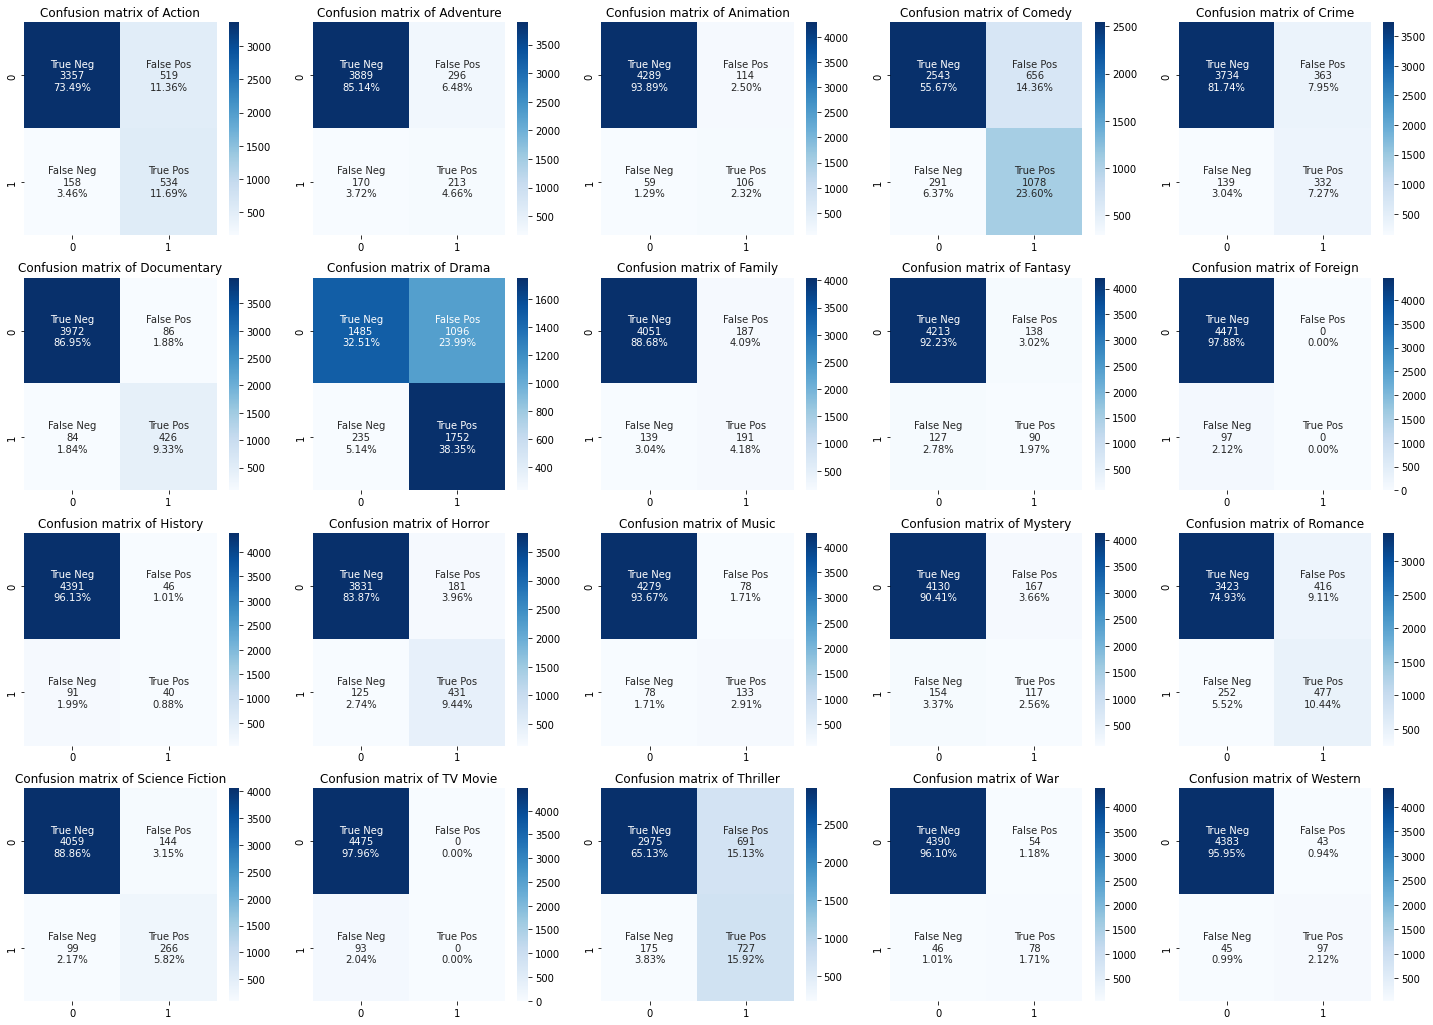

In [35]:
display_confusion_matrix(test_labels_transformed, y_pred, attributes)

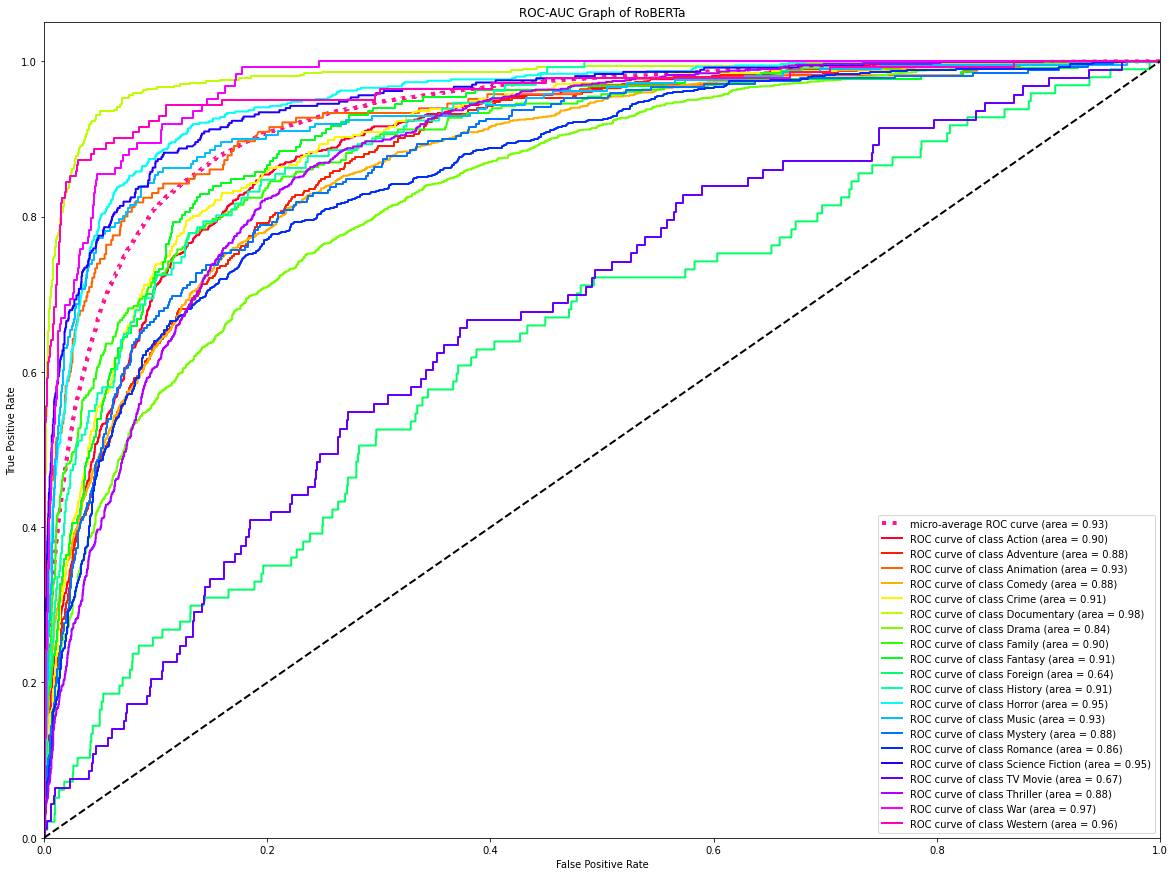

In [38]:
plot_roc_auc_graph(test_labels_transformed, prediction, attributes)

Removing genres that are not very meaningful slightly improve the final result.

In [33]:
y_pred_selected = np.delete(y_pred, [attributes.index('TV Movie'),attributes.index('Foreign')], 1)
test_labels_transformed_selected = np.delete(test_labels_transformed, [attributes.index('TV Movie'),attributes.index('Foreign')], 1)
selected_attributes = attributes
selected_attributes.remove('TV Movie')
selected_attributes.remove('Foreign')

In [37]:
f1_score(test_labels_transformed_selected, y_pred_selected, average='micro')

0.6467743407245186

In [38]:
precision_score(test_labels_transformed_selected, y_pred_selected, average='micro')

0.5733236269513872

In [39]:
recall_score(test_labels_transformed_selected, y_pred_selected, average='micro')

0.7418105703819989

In [40]:
accuracy_score(test_labels_transformed_selected, y_pred_selected)

0.20731173380035026

In [41]:
accuracy_score(test_labels_transformed_selected, y_pred_selected)

0.20731173380035026